# Movie Maker for TDMS files using FFMPEG

In [1]:
#http://www.wikihow.com/Install-FFmpeg-on-Windows
#https://matplotlib.org/api/animation_api.html

In [2]:
import numpy as np
import matplotlib
#matplotlib.use("agg")
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as animation

import fnmatch
import sys, os

from IPython.display import clear_output

from nptdms import TdmsFile # this library contains the actual TDMS loading parts
#from ipywidgets import interact

from matplotlib import colors
import pickle

In [3]:
fdir = 'E:/' # set the "Select Files..." dialog start directory to the notebook directory
def openFilesDialog(fdir):
    from PyQt5.QtWidgets import QApplication,QFileDialog
    app = QApplication([dir])
    files = QFileDialog.getOpenFileNames(None, "Select Files...", fdir, filter="All Files (*)")
    return files[0]

def loadTDMSImages(file):
    global exposure, dimx, dimy
    tdms_file = TdmsFile(file)
    p=tdms_file.object().properties   
    dimx=int(p['dimx'])  
    dimy=int(p['dimy'])
    frames=int(p['dimz'])
    exposure=float(p['exposure'])
    images=tdms_file.channel_data('Image','Image')
    return images.reshape(frames,dimx,dimy)

## Select files to process

In [58]:
files = openFilesDialog(fdir)
fdir = os.path.dirname(files[0]) # Set the dialogs start directory to the selected directory
print('Selected Files:')
for file in files:
    print(file)

Selected Files:
E:/180117_A-Beta_Trapping_Tests/Set3_007_movie.tdms


##  Select color map

In [59]:
cmap = pickle.load(open('cmap_tht.pkl', 'rb'))
#cmap = 'gray'

## Here, you can test the color scale and overlay

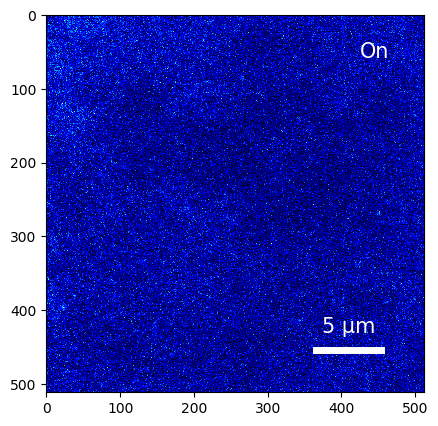

In [60]:
# Find the first *_movie.tdms file
i = [i for i, file in enumerate(files) if fnmatch.fnmatch(file, '*_movie.tdms')][0]
images = loadTDMSImages(files[i])

um2px = 0.0577; # µm/px
sb_um = 5; # µm 
sb_x = 0.8*dimx;
sb_y = 0.825*dimy;
sb_px = int(np.round(sb_um/um2px))

plt.figure(figsize=(5,5), dpi=100)
plt.imshow(images[0], cmap=cmap);
txt = plt.text(425, 50, 'On', va='center',ha='left',color='w',fontsize=15)
plt.text(sb_x, sb_y, str(sb_um) + ' µm', va='center',ha='center',color='w',fontsize=15);
plt.plot([sb_x-sb_px/2, sb_x+sb_px/2], [1.075*sb_y, 1.075*sb_y], 'w', lw=5);

## Process files individually

E:/180117_A-Beta_Trapping_Tests/Set3_007_movie.tdms
Progress: 90 %


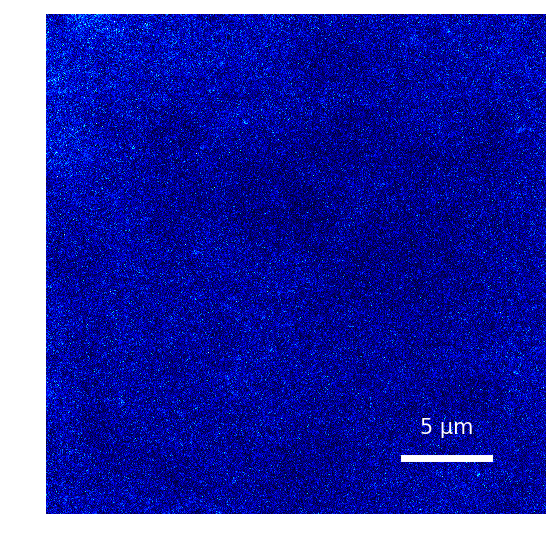

In [61]:
ffmpegWriter = animation.writers['ffmpeg']

fig = plt.figure(figsize=(5,5), dpi=100)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
im = plt.imshow(images[0], cmap=cmap) # vmax=...
# Scale Bar
plt.text(sb_x, sb_y, str(sb_um) + ' µm', va='center',ha='center',color='w',fontsize=15)
plt.plot([sb_x-sb_px/2, sb_x+sb_px/2], [1.075*sb_y, 1.075*sb_y], 'w', lw=5)
plt.axis('off')
        
images = np.zeros(0)        
for file in files:
    if fnmatch.fnmatch(file,'*_movie.tdms'): # load only the *_movie.tdms files of the selected files
        images = loadTDMSImages(file)
        if images.shape[0] > 1: # check if there is more than one frame
            writer = ffmpegWriter(fps=1./exposure) # ".mp4"
            with writer.saving(fig, file.replace('_movie.tdms','') + ".mp4", dpi=100): # !!!
                for i in range(images.shape[0]):
                    im.set_data(images[i])
                    writer.grab_frame()
                    if (i % 10 == 0):
                        clear_output(wait=True)
                        print(file + '\n' + 'Progress:', int(i/images.shape[0]*100), '%')

## Concatenate files

In [28]:
for file in files:
    if fnmatch.fnmatch(file, '*_movie.tdms'): # load only the *_movie.tdms files of the selected files
        if images.size == 0:
            images = loadTDMSImages(file)
        else:
            images = np.concatenate((images, loadTDMSImages(file)), axis=0)
print(images.shape)

(1302, 512, 512)


Progress: 99 %


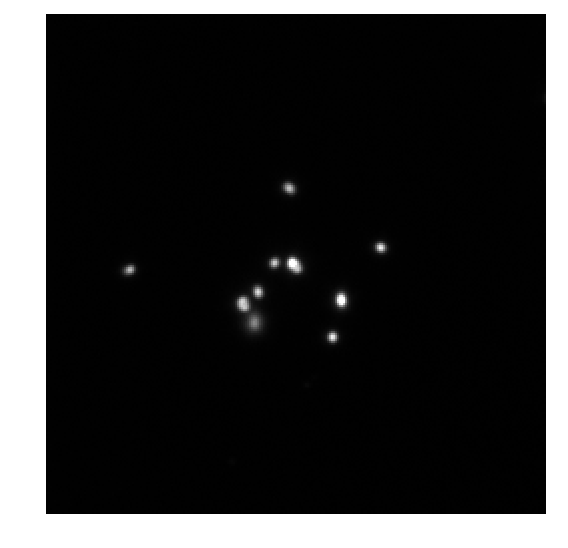

In [31]:
ffmpegWriter = animation.writers['ffmpeg']
#writer = ffmpegWriter(fps=1./exposure,codec="msvideo1") # + ".avi" for PowerPoint 2010
writer = ffmpegWriter(fps=1./exposure) # + ".mp4"

fig = plt.figure(figsize=(5,5), dpi=100)
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
im = plt.imshow(images[0], cmap='gray') # vmax=...
## Text
#txt = plt.text(sb_x, 50, 'Off', va='center',ha='left',color='w',fontsize=15)
## Scale Bar
#plt.text(sb_x, sb_y, str(sb_um) + ' µm', va='center',ha='center',color='w',fontsize=15)
#plt.plot([sb_x-sb_px/2, sb_x+sb_px/2], [sb_y+30, sb_y+30], 'w', lw=5)
# Trajectory
#l, = plt.plot([], [], 'w-', lw=1)
plt.axis('off')

with writer.saving(fig, files[0].replace('_001_movie.tdms','') + ".mp4", dpi=100):
    for i in range(images.shape[0]):
        im.set_data(images[i])
        # Text
        #if (i == 100):
        #    txt.set_text('On');
        # Trajectory
        #spots=pd.read_pickle(files[0].replace('_001_movie.tdms','') + '_spots.pkl')
        #l.set_data(spots[:i].x, spots[:i].y)
        writer.grab_frame()
        if (i % 10 == 0):
            clear_output(wait=True)
            print('Progress:', int(i/images.shape[0]*100), '%')

In [ ]:
### Process Selected Files Individually